# <font color='red'><ins>Práctica 2 FAA - Vecinos próximos & Regresión Logística</ins></font>
## Alejandro Santorum Varela - alejandro.santorum@estudiante.uam.es
## José Manuel Chacón Aguilera - josem.chacon@estudiante.uam.es

In [2]:
%load_ext autoreload
%autoreload 2

In [46]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [47]:
# My modules
from Datos import Datos
import EstrategiaParticionado
import Clasificador

# External modules
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Important to pre-install tabulate (pip install tabulate)
from tabulate import tabulate

# Init class Classifier
clasificador = Clasificador.Clasificador()

In [48]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data')
n1,m1 = db_pid.datos.shape
print("Numero de ejemplos:", n1,"| Numero de columnas:", m1)
print(db_pid.nominalAtributos)

Numero de ejemplos: 768 | Numero de columnas: 9
[False, False, False, False, False, False, False, False, True]


In [49]:
db_wdbc = Datos('../ConjuntosDatos/wdbc.data')
n2,m2 = db_wdbc.datos.shape
print("Numero de ejemplos:", n2,"| Numero de columnas:", m2)
print(db_wdbc.nominalAtributos)

Numero de ejemplos: 569 | Numero de columnas: 31
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True]


# <font color='red'>0. Normalización de datos </font>

Hemos considerado que el mejor sitio para implementar la normalización de datos es en la clase Datos (fichero Datos.py), ya que el prerrequisito de que los datos estén normalizados sólo depende de los datos en sí, y no de otros parámetros. 

Se ha añadido un argumento adicional al construcctor de la clase Datos llamado **normalize**, que por defecto está a False para no interferir en la práctica 1, pero si se indica *normalize=True* realizará el normalizado de datos directamente cuando los cargue en la matriz de datos.

Para realizar la normalización se han implementado dos nuevos métodos: *normalizarDatos* y *calcularMediasDesv*. La primera usa la segunda como función auxiliar.

calcularMediasDesv recibe la matriz de datos y la lista *nominalAtributos* que nos indica qué atributos son continuos. Esta función calcula las medias y las desviaciones típicas de cada uno de los atributos continuos, guardando estos datos en atributos de la clase Datos.

normalizarDatos recibe la matriz de datos y la lista *nominalAtributos*. Utilizando las listas de medias y desviaciones típicas calculadas con la otra función, normaliza los datos restando la media y dividiendo por la desviación típica correspondiente.

A continuación comprobamos el correcto funcionamiento de estos métodos, ejecutándolos para algunos atributos de ambos datasets y comparando sus resultados con los métodos de la clase *preprocessing* de SKLearn.

Mostramos los primeros atributos del conjunto de datos PID sin normalizar.

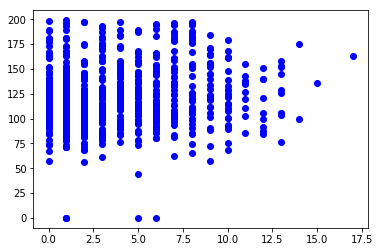

In [50]:
data = db_pid.datos
plt.plot(data[:,0], data[:,1], 'bo')

Ahora ejecutamos el método programado de normalziación y *plotteamos* la gráfica. Como podemos ver, los datos se han centrado en el (0,0) y la varianza se ha reducido.

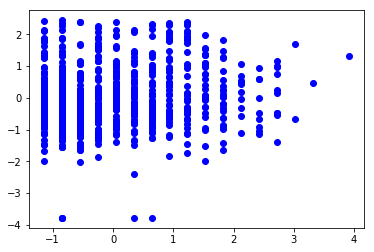

In [9]:
db_pid.normalizarDatos(db_pid.datos, db_pid.nominalAtributos)
data = db_pid.datos
plt.plot(data[:,0], data[:,1], 'bo')

Vamos a ver que la normalización es correcta comprobando que el resultado de los métodos de SKLearn es idéntico a la gráfica de arriba.

In [55]:
from sklearn import preprocessing

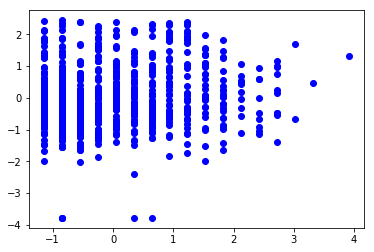

In [56]:
db_pid2 = Datos('../ConjuntosDatos/pima-indians-diabetes.data')

X_norm = preprocessing.scale(db_pid2.datos[:,:-1])

plt.plot(X_norm[:,0], X_norm[:,1], 'bo')

Vemos que las dos gráficas coinciden, indicándonos que, al menos para estos dos atributos, hemos normalizado correctamente

Probemos con otros atributos ahora.

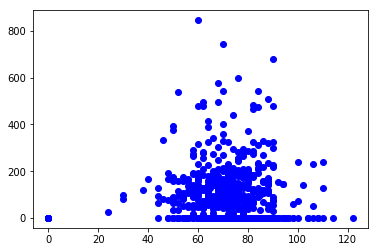

In [51]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data')
data = db_pid.datos
plt.plot(data[:,2], data[:,4], 'bo')

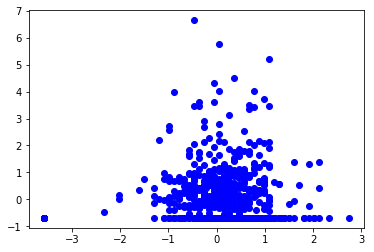

In [52]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=True)
data = db_pid.datos
plt.plot(data[:,2], data[:,4], 'bo')

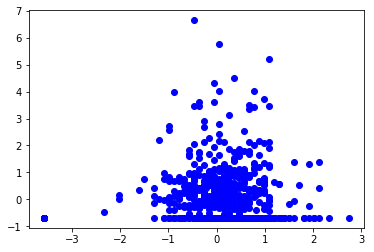

In [57]:
plt.plot(X_norm[:,2], X_norm[:,4], 'bo')

Vemos de nuevo que el resultado es el mismo. Podemos estar bastante confiados que normalizamos correctamente.

Para asegurarnos, repetimos lo mismo con la siguiente base de datos, WDBC.

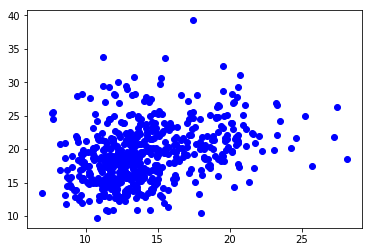

In [12]:
data = db_wdbc.datos
plt.plot(data[:,0], data[:,1], 'bo')

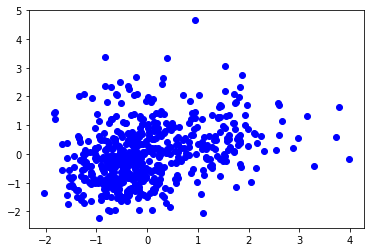

In [13]:
db_wdbc.normalizarDatos(db_wdbc.datos, db_wdbc.nominalAtributos)
data = db_wdbc.datos
plt.plot(data[:,0], data[:,1], 'bo')

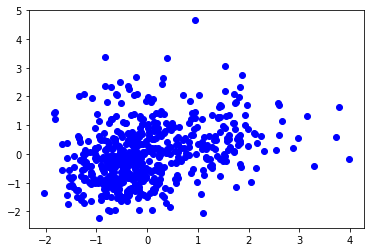

In [14]:
db_wdbc2 = Datos('../ConjuntosDatos/wdbc.data')

X_norm = preprocessing.scale(db_wdbc.datos[:,:-1])

plt.plot(X_norm[:,0], X_norm[:,1], 'bo')

De nuevo, las dos gráficas son iguales (la primera usando nuestras funciones de normalización y la segunda usando los métodos de sklearn). Ya estamos mucho más seguros de que nuestros métodos están bien implementados.

# <font color='red'>1. Vecinos próximos</font>


En las primeras fases de ejecución de este algoritmo fijaremos K=5 y variaremos la distancia utilizada para hacer unos primeros comentarios. Para terminar la sección ejecutaremos el algoritmo con todos los valores de K a analizar y todas las distancias posibles, escogiendo la mejor pareja de hiperparámetros para ambos conjuntos de entrenamiento.

## <font color='blue'> 1.1 Dataset pima-indians-diabetes </font>

Inicializamos los conjuntos de entrenamiento (uno normalizado y el otro no), así como las 3 estrategias de particionado que vamos a analizar:
   - Particionado simple (80% train - 20% test).
   - Particionado simple (80% train - 20% test) con 7 repeticiones.
   - Validación cruzada con 5 folds.

In [7]:
db_pid_notNorm = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=False)
print(db_pid_notNorm.datos.shape)

(768, 9)


In [8]:
db_pid_norm = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=True)
print(db_pid_norm.datos.shape)

(768, 9)


Como tenemos pocos ejemplos de entrenamiento (<1000) vamos a escoger un porcentaje alto para el particionado simple (~80%)

In [9]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)
strat_simple_rep7 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=7)
strat_cross_f5 = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

### 1.1.1 Distancia euclídea con datos sin normalizar

In [10]:
KNN_eucl = Clasificador.ClasificadorVecinosProximos(K=5, dist='euclidean')

Ejecutamos con validación simple.

In [12]:
errores = clasificador.validacion(strat_simple, db_pid_notNorm, KNN_eucl)
print('Error cometido:', errores)

Error cometido: [0.3116883116883117]


El error resultante con K=5, utilizando la distancia euclidea y con los datos SIN normalizar se concentra entre 25-32 %. Es aún pronto para hablar, esperemos a ver los resultados con otra estrategia de particionado (por ejemplo, simple con varias repeticiones) para tener una mejor estimación del error cometido.

Ejecutamos ahora varias repeticiones del particionado simple.

In [141]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_notNorm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.28478664192949904 +- 0.02675733785130977


Vemos que el error medio con K=5, utilizando la distancia euclidea y con los datos SIN normalizar se concentra entre 25-28%. La desviación típica es pequeña. Será interesante comparar estos resultados con los datos normalizados.

Ejecutamos ahora el mismo modelo pero con un particionado cruzado

In [142]:
errores = clasificador.validacion(strat_cross_f5, db_pid_notNorm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.27712418300653596 +- 0.045583256925915555


Tras utilizar validación cruzada podemos ratificar que el error con K=5, utilizando la distancia euclidea y con los datos SIN normalizar se concentra entre 25-28%. Veamos ahora que pasa si normalizamos los datos.


### 1.1.2 Distancia euclídea con datos normalizados

In [147]:
errores = clasificador.validacion(strat_simple, db_pid_norm, KNN_eucl)
print('Error cometido:', errores)

Error cometido: [0.2532467532467533]


El error resultante con K=5, utilizando la distancia euclidea y con los datos normalizados se concentra entre 22-27%. De primeras sí que parece que es beneficioso normalizar los datos. Hagámoslo con varias repeticiones.

In [150]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_norm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.2569573283858998 +- 0.02107201612541846


El error medio ha mejorado ligeramente tras normalizar los datos. Ahora parece que se concentra entre el 23-27%

In [154]:
errores = clasificador.validacion(strat_cross_f5, db_pid_norm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.25882352941176473 +- 0.035221421138058755


Ratificamos con validación cruzada lo dicho anteriormente. En este conjunto de entrenamiento la normalización de los datos mejora ligeramente el rendimiento del modelo.

Analicemos ahora los resultados con otras distancias.

### 1.1.3 Distancia de Manhattan con datos sin normalizar

In [13]:
KNN_manh = Clasificador.ClasificadorVecinosProximos(K=5, dist='manhattan')

Ejecutamos primero con particionado simple

In [14]:
errores = clasificador.validacion(strat_simple, db_pid_notNorm, KNN_manh)
print('Error cometido:', errores)

Error cometido: [0.3116883116883117]


A primera vista parece que la distancia de Manhattan funciona mejor para clasificar este conjunto de entrenamiento. De todas formas la evidencia estadística es prácticamente nula al haberlo ejecutado una sola vez. Esperemos para hablar.

In [15]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_notNorm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.26066790352504643 +- 0.024154390661023255


Tras repetirlo varias veces parece que la distancia de Manhattan mejora la precisión por un 0.01%. Esta diferencia es ínfima, puede haber sido simplemente en esta ejecución, pero será algo que deberemos prestar atención en las futuras secciones cuando escojamos los mejores hiperparámetros.

Ejecutamos ahora con validación cruzada.

In [162]:
errores = clasificador.validacion(strat_cross_f5, db_pid_notNorm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.2666666666666666 +- 0.01867040112037345


Error medio muy parecido al anterior. Lo que hemos dicho se mantiene. Ahora nuestro objetivo principal será discernir si conviene o no normalizar los datos.

### 1.1.4 Distancia de Manhattan con datos normalizados

Como siempre, primero con particionado simple.

In [166]:
errores = clasificador.validacion(strat_simple, db_pid_norm, KNN_manh)
print('Error cometido:', errores)

Error cometido: [0.24675324675324672]


A primera vista parece que la diferencia entre normalizar los datos y no hacerlo es ínfima. Ejecutémoslo varias veces para poder hablar con más fundamento.

In [167]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_norm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.26623376623376627 +- 0.032188036313353395


El error vuelve a ser menor que con los datos sin normalizar, pero la diferencia es ínfima. Esto puede ser debido a que los datos originales ya eran fácilmente separables.

Veamos el rendimiento con valiación cruzada.

In [111]:
errores = clasificador.validacion(strat_cross_f5, db_pid_norm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.269281045751634 +- 0.04203381749232295


El resultado medio sigue concentrándose entorno al 26%, y sigue siendo muy parecido a los resultados con los datos sin normalizar.

Ahora estudiaremos la distancia de Mahalanobis.

### 1.1.5 Distancia de Mahalanobis con datos sin normalizar

In [16]:
KNN_maha = Clasificador.ClasificadorVecinosProximos(K=5, dist='mahalanobis')

Empecemos como siempre por un particionado simple

In [174]:
errores = clasificador.validacion(strat_simple, db_pid_notNorm, KNN_maha)
print('Error cometido:', errores)

Error cometido: [0.27922077922077926]


Parece que la distancia de Mahalanobis tiene un rendimiento similar al modelo que usa la distancia euclídea. Aún es pronto para hablar ya que no tenemos evidencia estadística suficiente.

In [175]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_notNorm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.2625231910946197 +- 0.04769929548119647


Tras ejecutarlo varias veces podemos ver que el rendimiento es efectivamente similar al del modelo que usa la distancia euclidea. Vamos a realizar ahora una prueba con validación cruzada.

In [177]:
errores = clasificador.validacion(strat_cross_f5, db_pid_notNorm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.265359477124183 +- 0.056315448963498084


Tras estos resultados, vamos a estudiar el impacto de normalizar los datos o no en este dataset.

### 1.1.6 Distancia de Mahalanobis con datos normalizados

In [181]:
errores = clasificador.validacion(strat_simple, db_pid_norm, KNN_maha)
print('Error cometido:', errores)

Error cometido: [0.2272727272727273]


Este resultado no difiere demasiado de los que llevamos obteniendo hasta el momento. Ahora vamos a ejecutar esto mismo varias veces.

In [183]:
errores = clasificador.validacion(strat_simple_rep7, db_pid_norm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.25139146567717996 +- 0.028136829105942663


Vemos que el error cometido es ligeramente inferior al cometido con los datos sin normalizar. La distancia de mahalanobis aporta resultados también similares a los obtenidos con la distancia euclídea. Por ahora parece que la distancia de Manhattan es la más eficaz. Esto se analizará próximamente con más precisión.

In [185]:
errores = clasificador.validacion(strat_cross_f5, db_pid_norm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.26143790849673204 +- 0.027106459285395703


De nuevo, el error es similar a los casos anteriores.

A lo largo de esta sección nos hemos preocupado por tomar contacto con las distintas distancias en el algoritmo de vecinos próximos. En el siguiente subapartado veremos qué distancia y qué número de vecinos K es el más preciso.

Ahora nos centramos en comentar los resultados de este conjunto de entrenamiento normalizado y sin normalizar. A lo largo de la sección hemos visto que los resultados obtenido, al menos para este dataset, son muy parecidos. Esto es debido a que los datos ya eran fácilmente separables en su espacio de definición original. Sin embargo, es bien conocido que normalizar los datos es recomendable cuando usamos el modelo de vecinos próximos por lo visto en el capítulo 0.

Debido a que los resultados son similares con ambos conjuntos de entramiento (pima-indians-diabetes normalizado y sin normalizar), vamos a escoger una de sus formas (normalizado) para discernir qué hiperparámetros son los mejores.

### <font color='green'> 1.1.7 Resultados y selección de hiperparámetros </font>

En las subsecciones anteriores vimos que no existía una gran diferencia entre las estrategias de particionado utilizadas. Para escoger los mejores hiperparámetros vamos a utilizar validación cruzada (5 folds), por su robustez de resultados y por ser de las más utilizadas en la cultura del aprendizaje automático.

In [17]:
Ks = [1, 5, 11, 21]
dists = ['euclidean', 'manhattan', 'mahalanobis']

In [18]:
strat = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

+---------------+----------------+----------------+----------------+----------------+
| distancia/K   | 1              | 5              | 11             | 21             |
+===============+================+================+================+================+
| euclidean     | 0.319 +- 0.03  | 0.2732 +- 0.05 | 0.2693 +- 0.02 | 0.251 +- 0.04  |
+---------------+----------------+----------------+----------------+----------------+
| manhattan     | 0.3072 +- 0.02 | 0.2758 +- 0.03 | 0.2575 +- 0.02 | 0.2392 +- 0.04 |
+---------------+----------------+----------------+----------------+----------------+
| mahalanobis   | 0.3176 +- 0.07 | 0.2654 +- 0.02 | 0.2627 +- 0.04 | 0.2667 +- 0.04 |
+---------------+----------------+----------------+----------------+----------------+


[]

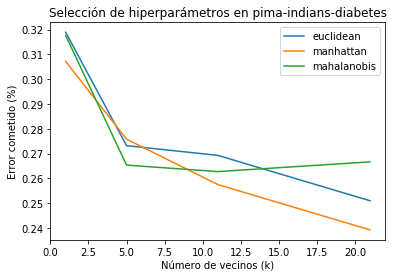

In [23]:
L = []
for d in dists:
    distance_results = []
    for k in Ks:
        KNN = Clasificador.ClasificadorVecinosProximos(K=k, dist=d)
        errores = clasificador.validacion(strat, db_pid_norm, KNN)
        err = (np.mean(errores), np.std(errores))
        distance_results.append(err)
    l = [d] + [str(round(item[0], 4))+' +- '+str(round(item[1],2)) for item in distance_results]
    L.append(l)
    errs = [item[0] for item in distance_results]
    plt.plot(Ks, errs, label=d)

print(tabulate(L, headers=['distancia/K']+Ks, tablefmt="grid"))

plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error cometido (%)')
plt.legend(loc='upper right')
plt.title('Selección de hiperparámetros en pima-indians-diabetes')
plt.plot()

Ejecutando la celda anterior varias veces podemos ver que, por lo general, la distancia que mejor rendimiento aporta es la distancia de Manhattan. A veces obtenemos que la distancia euclídea es la que tiene mejor precisón, pero en menos ocasiones.

Lo que está siempre claro es que el número de vecinos óptimos en la lista a analizar es k=21.

Comentar finalmente que no es de extrañar que la mejor distancia sea la de Manhattan, ya que en este dataset ciertos atributos tienen una relación lineal. Véase la siguiente celda como ejemplo.

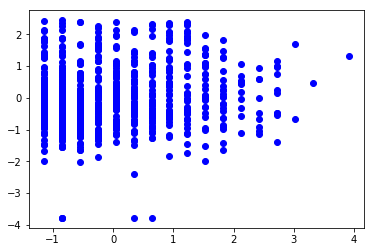

In [198]:
plt.plot(db_pid_norm.datos[:,0], db_pid_norm.datos[:,1], 'bo')

Concluimos esta sección ratificando los mejores resultados:
- Es **recomendable**, aunque no indispensable en este dataset, **normalizar** los datos.
- Sin duda, el mejor **número de vecinos** entre los analizados es **k=21**.
- La **distancia** que generalmente aporta mejores resultados es la **distancia de Manhattan**. En menor medida, también es aceptable la **distancia euclídea**.

## <font color='blue'> 1.2 Dataset WDBC </font>

Estudiamos ahora el algoritmo de Vecinos Próximos con un nuevo conjunto de entrenamiento: WDBC.

Como antes, analizamos dos conjuntos de entrenamiento (uno normalizado y el otro no), así como las 3 estrategias de particionado siguientes:
   - Particionado simple (80% train - 20% test).
   - Particionado simple (80% train - 20% test) con 7 repeticiones.
   - Validación cruzada con 5 folds.
   
Adicionalmente, volvemos a centrarnos en comprender el comportamiento de las distancias con los distintos datos, sin variar el número de vecinos, fijándolo a k=5.

In [26]:
db_wdbc_notNorm = Datos('../ConjuntosDatos/wdbc.data', normalize=False)
print(db_wdbc_notNorm.datos.shape)

(569, 31)


In [27]:
db_wdbc_norm = Datos('../ConjuntosDatos/wdbc.data', normalize=True)
print(db_wdbc_norm.datos.shape)

(569, 31)


### 1.2.1 Distancia euclídea con datos sin normalizar

In [213]:
errores = clasificador.validacion(strat_simple, db_wdbc_notNorm, KNN_eucl)
print('Error cometido:', errores)

Error cometido: [0.07017543859649122]


El error cometido parece que se concentra, con k=5, distancia euclídea y datos sin normalizar, entorno al 7%. Repitámoslo varias veces.

In [207]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_notNorm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.07894736842105265 +- 0.018159619982693536


Ratificamos lo dicho anteriormente, el error se concentra cerca del 7%. Esperamos ahora a ver los resultados con los datos normalizados para comparar.

In [210]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_notNorm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.06194690265486724 +- 0.009694204557613575


Con validación cruzada obtenemos resultados similares.

Ahora veamos qué resultados conseguimos normalizando los datos.

### 1.2.2 Distancia euclídea con datos normalizados

In [220]:
errores = clasificador.validacion(strat_simple, db_wdbc_norm, KNN_eucl)
print('Error cometido:', errores)

Error cometido: [0.03508771929824561]


Parece que el error cometido ha bajado un 50%, es decir, el error con el conjunto de datos normalizado se concentra entorno al 3%. Repitamos esto varias veces.

In [222]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_norm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.03759398496240602 +- 0.009036469362065164


Efectivamente, existe evidencia estadística de que el error ha bajado considerablemente normalizando los datos. Parece que este conjunto de entrenamiento es difícilmente separable en su soporte de definición y que traslandándolo y escalándolo por su media y desviación típica se puede separar con mayor facilidad.

In [223]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, KNN_eucl)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.03539823008849559 +- 0.014808142062549993


La ejecución usando validación cruzada nos confirma lo dicho hasta ahora: normalizar los datos es importante.

En las próximas subsecciones seguiremos analizando la importancia de normalizar los datos, junto con la comparación de rendimientos usando diferentes distancias.

### 1.2.3 Distancia de Manhattan con datos sin normalizar

Empezamos usando una estrategia de particionado simple

In [226]:
errores = clasificador.validacion(strat_simple, db_wdbc_notNorm, KNN_manh)
print('Error cometido:', errores)

Error cometido: [0.07017543859649122]


El error parece que se sigue concentrando en 7% con la distancia de Manhattan. Habrá que esperar a futuras secciones para tener un argumento contundente sobre qué distancia es mejor.

In [225]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_notNorm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.07518796992481203 +- 0.02429914715496906


Ratificamos los dicho, se sigue concentrando entorno al 7%

In [227]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_notNorm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.06194690265486726 +- 0.017699115044247784


La validación cruzada parece que es una estrategia a seguir para conseguir mejores resultados.

### 1.2.4 Distancia de Manhattan con datos normalizados

Empezamos usando una estrategia de particionado simple

In [242]:
errores = clasificador.validacion(strat_simple, db_wdbc_norm, KNN_manh)
print('Error cometido:', errores)

Error cometido: [0.03508771929824561]


Con la distancia de Manhattan también se obtienen mejores resultados si normalizamos los datos. Repitámoslo más veces.

In [244]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_norm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.033834586466165405 +- 0.012779497527801451


Seguimos obteniendo un error concentrado en el 3%.

In [245]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, KNN_manh)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.03539823008849559 +- 0.007915284876105414


El error vuelve a ser del 3% con validación cruzada. Analizamos ahora la distancia de Mahalanobis.


### 1.2.5 Distancia de Mahalanobis con datos sin normalizar

Empezamos usando una estrategia de particionado simple

In [249]:
errores = clasificador.validacion(strat_simple, db_wdbc_notNorm, KNN_maha)
print('Error cometido:', errores)

Error cometido: [0.1578947368421053]


Podemos ver en un primer momento que la distancia de Mahalanobis aporta peores resultados que las dos anteriores. Es pronto para hablar, por loque lo vamos a ejecutar varias veces.

In [250]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_notNorm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.19172932330827067 +- 0.03644872073245359


Pues efectivamente, la distancia de Mahalanobis tiene un rendimiento pésimo en este dataset comparado con las dos anteriores. ¿Será culpa del normalizado de datos? Lo veremos en la próxima subsección.

In [251]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_notNorm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.20176991150442483 +- 0.043856678560580085


Vemos que la validación cruzada no hace milagros.

### 1.2.6 Distancia de Mahalanobis con datos normalizados

Empezamos usando una estrategia de particionado simple

In [254]:
errores = clasificador.validacion(strat_simple, db_wdbc_norm, KNN_maha)
print('Error cometido:', errores)

Error cometido: [0.1578947368421053]


Parece que la normalización de datos no era el problema principal. Ejecutémoslo varias veces.

In [256]:
errores = clasificador.validacion(strat_simple_rep7, db_wdbc_norm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.19924812030075187 +- 0.03436418346065684


Como era de esperar, la distancia de Mahalanobis sigue siendo el problema principal. Vemos que desde luego no la usaríamos para entrenar este conjunto de datos.

In [257]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, KNN_maha)
print('Error medio', np.mean(errores), '+-', np.std(errores))

Error medio 0.1752212389380531 +- 0.04240406566623343


La validacón cruzada solo ratifica lo visto anteriormente.

Vamos a fijar la estrategia de particionado de validación cruzada ya que no existen grandes diferencias entre ellas. Adicionalmente, para seleccionar los mejores hiperparámetros, vamos a utilizar el conjunto de datos normalizado ya que es obvio que aporta un mejor rendimiento al modelo.

### <font color='green'> 1.2.7 Resultados y selección de hiperparámetros </font>

+---------------+----------------+----------------+----------------+----------------+
| distancia/K   | 1              | 5              | 11             | 21             |
+===============+================+================+================+================+
| euclidean     | 0.0531 +- 0.01 | 0.0372 +- 0.02 | 0.0336 +- 0.02 | 0.0442 +- 0.02 |
+---------------+----------------+----------------+----------------+----------------+
| manhattan     | 0.0531 +- 0.01 | 0.0301 +- 0.01 | 0.0389 +- 0.03 | 0.046 +- 0.02  |
+---------------+----------------+----------------+----------------+----------------+
| mahalanobis   | 0.177 +- 0.03  | 0.1894 +- 0.02 | 0.2319 +- 0.04 | 0.2814 +- 0.06 |
+---------------+----------------+----------------+----------------+----------------+


[]

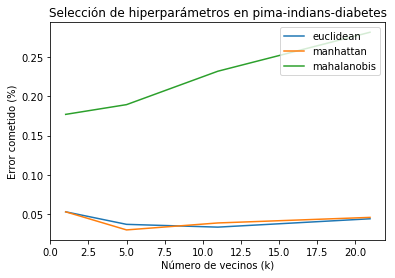

In [28]:
L = []
for d in dists:
    distance_results = []
    for k in Ks:
        KNN = Clasificador.ClasificadorVecinosProximos(K=k, dist=d)
        errores = clasificador.validacion(strat, db_wdbc_norm, KNN)
        err = (np.mean(errores), np.std(errores))
        distance_results.append(err)
    l = [d] + [str(round(item[0], 4))+' +- '+str(round(item[1],2)) for item in distance_results]
    L.append(l)
    errs = [item[0] for item in distance_results]
    plt.plot(Ks, errs, label=d)

print(tabulate(L, headers=['distancia/K']+Ks, tablefmt="grid"))

plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error cometido (%)')
plt.legend(loc='upper right')
plt.title('Selección de hiperparámetros en pima-indians-diabetes')
plt.plot()

Ejecutando la celda anterior varias veces podemos ver que, por lo general, la distancia euclidea y de Manhattan son las que mejor rendimiento aportan. Por lo general, la distancia euclídea es ligeramente mejor que la de Manhattan. Lo que esta clarísimo, es que la distancia de Mahalanobis no es adecuada para entrenar este dataset.

Por otro lado, el número de vecinos (k) óptimo es o 5 u 11, con resultados muy similares. Por lo general, k=1 y k=21 tienen peores resultados. Como para k=5 y k=11 los resultados son tan parecidos, podríamos escoger cualquiera de los dos valores.

Comentar finalmente que no es de extrañar que los datos normalizados aporten mejores resultados. Este conjunto de entrenamiento tenían grandes diferencias de escala entre sus atributos y la normalización permite que todos ellos se definan en un espacio más homogéneo, permitiendonos trabajar mejor con las distancias y obtener una precisión mayor.

Concluimos esta sección ratificando los mejores resultados:
- Es **importante** **normalizar** los datos de este conjunto.
- El mejor **número de vecinos** entre los analizados es **k=5** ó **k=11**.
- La **distancia** que generalmente aporta mejores resultados es la **distancia de euclídea**, aunque la **distancia de Manhattan** también aporta resultados similares.

# <font color='red'>2. Regresión Logística</font>

Como en el capítulo anterior, vamos a ejecutar nuestra implementación de Regresión Logística comparando los resultados con diferentes hiperparámetros (en este caso constante de aprendizaje y números de épocas de entrenamiento) y con ambos datasets. Adicionalmente, es necesario normalizar los datos ya que la función sigmoide utilizada para entrenar y predecir en el modelo de regresión logística crece exponencialmente. Si los datos son en magnitud muy grandes, vamos a tener problemas de overflow. 

Las estrategias de particionado que usaremos serán validación simple con 7 repeticiones y validación cruzada con 5 folds. No usaremos validación simple con 1 repetición ya que el resultado que incluimos con 7 repeticiones es mucho más preciso.

Analizaremos en estas subsecciones 3 constantes de aprendizaje: 0.05, 0.1 y 0.5. En la subsección de cálculo de hiperparámetros se probarán más, pero para realizar el estudio inicial nos bastará con estos 3. Por otro lado, ejecutamos con 50, 100 y 150 épocas en estas subsecciones.

In [32]:
# Funcion auxiliar para analizar el rendimiento de regresión logística.
# Recibe una lista de constantes de aprendizaje y una lista de número de épocas con las que ejecutar RL.
# Como salida, muestra una tabla con los errores medios obtenidos y una gráfica comparando los resultados.

def run_logReg(lr_list, epochs_list, dataset, db_name, strat):
    L = []
    for lr in lr_list:
        results = []
        for nepochs in epochs_list:
            RL = Clasificador.ClasificadorRegresionLogistica(learning_rate=lr, nepochs=nepochs)
            errores = clasificador.validacion(strat, dataset, RL)
            err = (np.mean(errores), np.std(errores))
            results.append(err)
        l = [lr] + [str(round(item[0], 4))+' +- '+str(round(item[1],2)) for item in results]
        L.append(l)
        errs = [item[0] for item in results]
        plt.plot(epochs_list, errs, label='Learning rate: '+str(lr))

    print(tabulate(L, headers=['LR/nepocas']+epochs_list, tablefmt="grid"))

    plt.xlabel('Número de epocas (nepocas)')
    plt.ylabel('Error cometido (%)')
    plt.legend(loc='upper right')
    plt.title('Selección de hiperparámetros en '+db_name)
    plt.plot()

In [33]:
lr_list = [0.05, 0.1, 0.5]
epochs_list = [50, 100, 150]

## <font color='blue'> 2.1 Dataset pima-indians-diabetes </font>

### 2.1.1 Validación simple con 7 repeticiones

Empezamos estudiandolo con validación simple con 7 repeticiones

+--------------+----------------+----------------+----------------+
|   LR/nepocas | 50             | 100            | 150            |
+==============+================+================+================+
|         0.05 | 0.2523 +- 0.04 | 0.244 +- 0.04  | 0.2338 +- 0.03 |
+--------------+----------------+----------------+----------------+
|         0.1  | 0.2338 +- 0.04 | 0.2319 +- 0.02 | 0.2523 +- 0.03 |
+--------------+----------------+----------------+----------------+
|         0.5  | 0.2718 +- 0.05 | 0.2737 +- 0.02 | 0.2931 +- 0.02 |
+--------------+----------------+----------------+----------------+


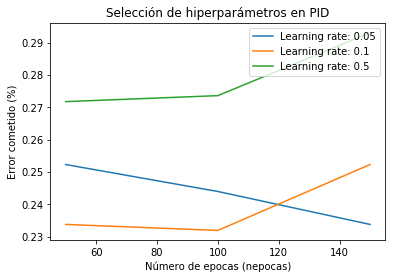

In [34]:
run_logReg(lr_list, epochs_list, db_pid_norm, 'PID', strat_simple_rep7)

Vemos en la tabla que el mejor valor (entre los analizados) para la constante de aprendizaje es 0.05. En cuanto al número de épocas, el mínimo se alcanza antes de las 150 epocas, aunque con 150 tampoco empeora mucho el resultado. Una solución que se podría implementar en una futura práctica o en una mejora de nuestra librería sería implementar 'early stopping', que se encarga de parar el entrenamiento aunque no hayan finalizado las épocas si el error no mejora. 

### 2.1.2 Validación cruzada con 5 folds

+--------------+----------------+----------------+----------------+
|   LR/nepocas | 50             | 100            | 150            |
+==============+================+================+================+
|         0.05 | 0.234 +- 0.02  | 0.2444 +- 0.04 | 0.2248 +- 0.02 |
+--------------+----------------+----------------+----------------+
|         0.1  | 0.2353 +- 0.04 | 0.2275 +- 0.02 | 0.2601 +- 0.02 |
+--------------+----------------+----------------+----------------+
|         0.5  | 0.298 +- 0.05  | 0.2876 +- 0.04 | 0.2601 +- 0.03 |
+--------------+----------------+----------------+----------------+


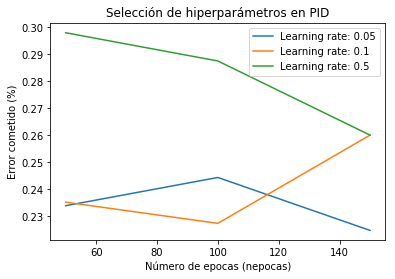

In [35]:
run_logReg(lr_list, epochs_list, db_pid_norm, 'PID', strat_cross_f5)

Con validación cruzada obtenemos los mismos resultados. El peor *learning rate* es 0.5, posiblemente debido a que el algoritmo es muy sensible a los cambios de gradiente y le cuesta caer en un mínimo global de la función de coste. La constante lr=0.1 mejora los resultados y, otra vez, el mejor valor para la constante de entrenamiento es 0.05. En este caso las 150 épocas tampoco han sido estrictamente necesarias para conseguir una buena precisión.

El error mínimo cometido no ha variado mucho entre validación simple (7 reps) y validacion cruzada (5folds), ya que éste se concentra al rededor del 21-22%. Para el siguiente apartado, donde buscaremos conseguir los mejores hiperparámetros para este conjunto de datos, utilizaremos únicamente validación cruzada.

### <font color='green'> 2.1.3 Resultados y selección de hiperparámetros </font>

In [65]:
lr_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
epochs_list = [50, 100, 150, 200, 250, 300]

+--------------+----------+----------+----------+----------+----------+----------+
|   LR/nepocas |       50 |      100 |      150 |      200 |      250 |      300 |
+==============+==========+==========+==========+==========+==========+==========+
|        0.001 | 0.224837 | 0.223529 | 0.236601 | 0.224837 | 0.222222 | 0.237908 |
+--------------+----------+----------+----------+----------+----------+----------+
|        0.005 | 0.227451 | 0.226144 | 0.222222 | 0.220915 | 0.233987 | 0.220915 |
+--------------+----------+----------+----------+----------+----------+----------+
|        0.01  | 0.228758 | 0.226144 | 0.233987 | 0.224837 | 0.227451 | 0.23268  |
+--------------+----------+----------+----------+----------+----------+----------+
|        0.05  | 0.226144 | 0.228758 | 0.220915 | 0.231373 | 0.224837 | 0.233987 |
+--------------+----------+----------+----------+----------+----------+----------+
|        0.1   | 0.257516 | 0.227451 | 0.226144 | 0.248366 | 0.228758 | 0.240523 |
+---

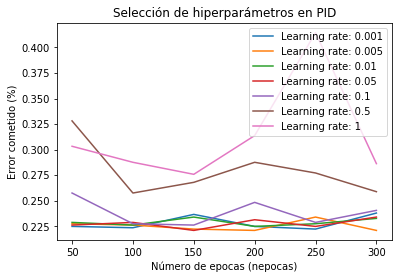

In [67]:
run_logReg(lr_list, epochs_list, db_pid_norm, 'PID', strat_cross_f5)

Vemos que los mayores *learning_rates* son los peores. Por otro lado, parece que el error se ha estabilizado entorno al 22-23% pero vamos a realizar unas cuantas más épocas para reafirmarlo.

In [68]:
lr_list_max = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
epochs_list_max = [50, 100, 150, 200, 250, 300, 350, 400]

+--------------+----------+----------+----------+----------+----------+----------+----------+----------+
|   LR/nepocas |       50 |      100 |      150 |      200 |      250 |      300 |      350 |      400 |
+==============+==========+==========+==========+==========+==========+==========+==========+==========+
|       0.0001 | 0.287582 | 0.244444 | 0.236601 | 0.236601 | 0.237908 | 0.223529 | 0.227451 | 0.233987 |
+--------------+----------+----------+----------+----------+----------+----------+----------+----------+
|       0.0005 | 0.23268  | 0.224837 | 0.224837 | 0.223529 | 0.231373 | 0.23268  | 0.224837 | 0.224837 |
+--------------+----------+----------+----------+----------+----------+----------+----------+----------+
|       0.001  | 0.223529 | 0.216993 | 0.227451 | 0.220915 | 0.224837 | 0.226144 | 0.220915 | 0.228758 |
+--------------+----------+----------+----------+----------+----------+----------+----------+----------+
|       0.005  | 0.228758 | 0.222222 | 0.226144 | 0.216

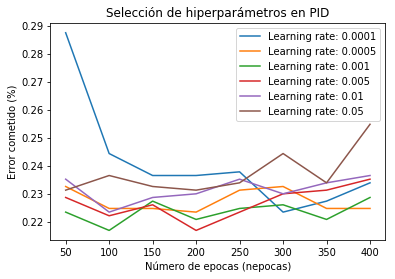

In [71]:
run_logReg(lr_list_max, epochs_list_max, db_pid_norm, 'PID', strat_cross_f5)

Efectivamente, el error se concentra entre 22% y 23%. Parece que la mejor constante de entrenamiento se encuentra entre 0.0005 y 0.005. La constante 0.0001 ya es muy pequeña (apenas se actualizan los pesos tras cada iteración del algoritmo de regresión logística), y a partir de 0.01 el gradiente toma mucho peso y complica el descubrimiento de un mínimo de la función de coste.

Concluimos esta sección ratificando los mejores resultados:
- Es **importante** **normalizar** los datos de este conjunto.
- La **mejor constante de entrenamiento** se sitúa en torno al **0.001 (0.005-0.0005)**.
- El **número de épocas** adecuado es más difícil de discernir, pero viendo la poca varianza del error obtenido podemos sostener que **300 épocas** son suficientes para acercarnos al 22% de error (record en este dataset con RL).

## <font color='blue'> 2.2 Dataset WDBC </font>

Viendo los resultados del apartado anterior vamos a modificar la lista inicial de constantes de aprendizaje

In [72]:
lr_list = [0.001, 0.005, 0.01, 0.05]
epochs_list = [50, 100, 150, 200]

### 2.2.1 Validación simple con 7 repeticiones

+--------------+-----------+-----------+-----------+-----------+
|   LR/nepocas |        50 |       100 |       150 |       200 |
+==============+===========+===========+===========+===========+
|        0.001 | 0.0238095 | 0.0238095 | 0.0225564 | 0.018797  |
+--------------+-----------+-----------+-----------+-----------+
|        0.005 | 0.0350877 | 0.0162907 | 0.0200501 | 0.0263158 |
+--------------+-----------+-----------+-----------+-----------+
|        0.01  | 0.0350877 | 0.0213033 | 0.0275689 | 0.0225564 |
+--------------+-----------+-----------+-----------+-----------+
|        0.05  | 0.0238095 | 0.037594  | 0.0338346 | 0.0288221 |
+--------------+-----------+-----------+-----------+-----------+


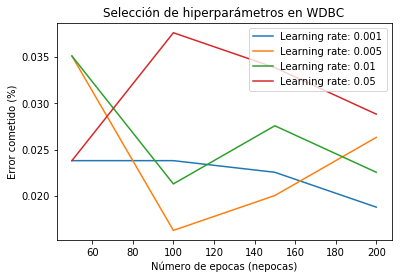

In [77]:
run_logReg(lr_list, epochs_list, db_wdbc_norm, 'WDBC', strat_simple_rep7)

Analizando la tabla y la gráfica podemos ver que la constante 0.001 es la que arroja resultados más consistentes, ya que el error se sitúan siempre entre el 2% y el 2.5%. No obstante, el mejor resultado se produce tras 100 épocas por parte del modelo que usa una constante de aprendizaje de 0.005. Es importante recordar que estos resultados pueden variar de una ejecución a otra; lo ideal sería tener un computador muy potente para poder procesar un gran número de iteraciones y épocas.

En la próxima sección compararemos estos resultados con los producidos con una estrategia de particionado cruzada.

### 2.2.2 Validación cruzada con 5 folds

+--------------+-----------+-----------+-----------+-----------+
|   LR/nepocas |        50 |       100 |       150 |       200 |
+==============+===========+===========+===========+===========+
|        0.001 | 0.0212389 | 0.019469  | 0.0230088 | 0.0247788 |
+--------------+-----------+-----------+-----------+-----------+
|        0.005 | 0.0159292 | 0.0247788 | 0.0212389 | 0.0283186 |
+--------------+-----------+-----------+-----------+-----------+
|        0.01  | 0.0230088 | 0.019469  | 0.0212389 | 0.0265487 |
+--------------+-----------+-----------+-----------+-----------+
|        0.05  | 0.0300885 | 0.0300885 | 0.0283186 | 0.0336283 |
+--------------+-----------+-----------+-----------+-----------+


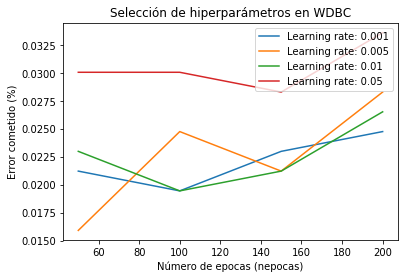

In [78]:
run_logReg(lr_list, epochs_list, db_wdbc_norm, 'WDBC', strat_cross_f5)

Las constantes de aprendizaje más bajas siguen siendo las que mejor rendimiento aportan: entorno al 2% de error medio. Podemos además que la estrategia de validación cruzada muestra mejores resultados que la validación simple, por esa razón, utilizaremos esta estrategia para la siguiente subsección, donde buscaremos los mejores hiperparámetros.

### <font color='green'> 2.1.3 Resultados y selección de hiperparámetros </font>

In [79]:
lr_list_max = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
epochs_list_max = [50, 100, 150, 200, 250, 300, 350, 400]

Los datos aportados por la siguiente tabla son errores medios del modelo de regresión logística.

+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|   LR/nepocas |        50 |       100 |       150 |       200 |       250 |       300 |       350 |       400 |
+==============+===========+===========+===========+===========+===========+===========+===========+===========+
|       0.0001 | 0.0690265 | 0.0353982 | 0.040708  | 0.0300885 | 0.0353982 | 0.0230088 | 0.0283186 | 0.0230088 |
+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|       0.0005 | 0.0318584 | 0.0212389 | 0.0247788 | 0.0212389 | 0.0212389 | 0.0230088 | 0.0230088 | 0.0247788 |
+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|       0.001  | 0.0230088 | 0.0212389 | 0.0159292 | 0.0212389 | 0.0247788 | 0.0247788 | 0.019469  | 0.019469  |
+--------------+-----------+-----------+-----------+-----------+-----------+-----------+--------

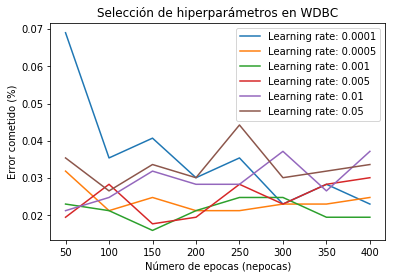

In [82]:
run_logReg(lr_list_max, epochs_list_max, db_wdbc_norm, 'WDBC', strat_cross_f5)

Finalmente podemos ver que las mejores constantes de entrenamiento son las pequeñas, 0.0005 y 0.001 aportan buenos resultados. lr=0.0001 acaba bien peri se muestra bastante incosistente a lo largo del eje x (número de épocas). Sin capacidad para realizar un número de épocas estratosférico, podemos decir que un buen ratio de aprendizaje es 0.001. Por otro lado, en cuanto al número de épocas, no hay mucha diferencia entre los errores cometidos entre un número de épocas menor o uno un poco mayor. Entre 150 y 300 épocas puede estar un número adecuado (con buenos resultados) y a la vez cómodo (con un tiempo de ejecución relativamente bajo).

Concluimos esta sección ratificando los mejores resultados:
- Es **importante** **normalizar** los datos de este conjunto.
- La **mejor constante de entrenamiento** se sitúa en torno al **0.001 (0.005-0.0001)**.
- El **número de épocas** adecuado es más difícil de discernir, pero viendo la poca varianza del error obtenido podemos sostener que **150-300 épocas** son suficientes para incluso bajar el 2% de error (record en este dataset con RL).

# <font color='red'>3. Clasificadores de Scikit-Learn y comparación de resultados</font>

## <font color='blue'> 3.1 Vecinos próximos de SKLearn</font>

La implementación de Vecinos Próximos en la librería scikit-learn es bastante parecida a la nuestra. La librería también está implementada de tal manera que recibe un parámetro *n_neighbors* que indica el número de vecinos más próximos, lo que nosotros llamamos **k**. Por otro lado, la SKLearn recibe la distancia a usar mediante el parámetro *metric*, que entre otras muchas, puede ser 'euclidean', 'manhattan' o 'mahalanobis', exactamente igual que nosotros.
SKLearn permite crear una clase del modelo de vecinos próximos con más parámetros que nosotros, pero que no nos serán útiles en esta práctica. 

Por otro lado, vamos a comentar una particularidad de la distancia de 'mahalanobis'. Resulta que un argumento para calcular esta distancia es la matriz de covarianzas muestral, comúnmente denotada como \Sigma. Nosotros, en el encapsulamiento del modelo de scikit-learn en nuestras cabeceras, hemos decidido calcular la matriz de covarianzas en el entrenamiento, donde recibimos la matriz Xtrain y es con ella, ayudádonos de la función np.cov(x) de numpy, con la que calculamos \Sigma. Por tanto, en el momento de la clasificación, ya tendríamos este argumento preparado para ser usado.

Implementamos la siguiente función que se encargará de realizar todas las ejecuciones de ClasificadorVecinosProximosSK, que encapsula internamente los métodos de SKLearn para Vecinos Próximos. A este método le pasamos la lista de distancia a utilizar y una lista de valores K a testear. Adicionalmente le indicamos el conjunto de entrenamiento y la estrategia de particionado.

In [40]:
def run_knnSK(dists, Ks, strat, dataset, db_name):
    L = []
    for d in dists:
        distance_results = []
        for k in Ks:
            KNNSK = Clasificador.ClasificadorVecinosProximosSK(K=k, dist=d)
            errores = clasificador.validacion(strat, dataset, KNNSK)
            err = (np.mean(errores), np.std(errores))
            distance_results.append(err)
        l = [d] + [str(round(item[0], 4))+' +- '+str(round(item[1],2)) for item in distance_results]
        L.append(l)
        errs = [item[0] for item in distance_results]
        plt.plot(Ks, errs, label=d)

    print(tabulate(L, headers=['distancia/K']+Ks, tablefmt="grid"))

    plt.xlabel('Número de vecinos (k)')
    plt.ylabel('Error cometido (%)')
    plt.legend(loc='upper right')
    plt.title('Selección de hiperparámetros en '+db_name)
    plt.plot()

### 3.1.1 Dataset pima-indians-diabetes

Empezamos mirando el rendimiento en el dataset pima-indians-diabetes

In [41]:
dists = ['euclidean', 'manhattan', 'mahalanobis']
Ks = [1, 5, 11, 21]

#### 3.1.1.1 Datos sin normalizar

+---------------+----------------+----------------+----------------+----------------+
| distancia/K   | 1              | 5              | 11             | 21             |
+===============+================+================+================+================+
| euclidean     | 0.3255 +- 0.02 | 0.2824 +- 0.03 | 0.2641 +- 0.04 | 0.2588 +- 0.02 |
+---------------+----------------+----------------+----------------+----------------+
| manhattan     | 0.3085 +- 0.03 | 0.2863 +- 0.03 | 0.251 +- 0.04  | 0.2588 +- 0.05 |
+---------------+----------------+----------------+----------------+----------------+
| mahalanobis   | 0.3059 +- 0.02 | 0.268 +- 0.04  | 0.2549 +- 0.02 | 0.2627 +- 0.03 |
+---------------+----------------+----------------+----------------+----------------+


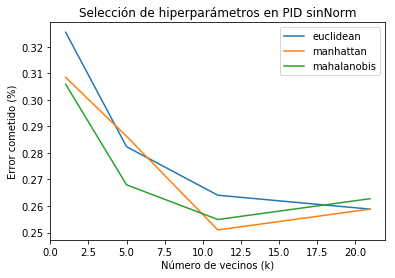

In [42]:
run_knnSK(dists, Ks, strat_cross_f5, db_pid_notNorm, "PID sinNorm")

Vemos que los resultados son parecidos para todas las distancias (si recordamos, esto pasaba también con nuestra implementación). Parece que el mejor valor para k es 11 o 21. Analizaremos esto con mayor detalle en futuras subsecciones, pero ahora veremos si existe una gran diferencia con el conjunto de datos normalizado.

#### 3.1.1.2 Datos normalizados

+---------------+----------+----------+----------+----------+
| distancia/K   |        1 |        5 |       11 |       21 |
+===============+==========+==========+==========+==========+
| euclidean     | 0.312418 | 0.275817 | 0.257516 | 0.249673 |
+---------------+----------+----------+----------+----------+
| manhattan     | 0.304575 | 0.281046 | 0.243137 | 0.244444 |
+---------------+----------+----------+----------+----------+
| mahalanobis   | 0.295425 | 0.262745 | 0.260131 | 0.254902 |
+---------------+----------+----------+----------+----------+


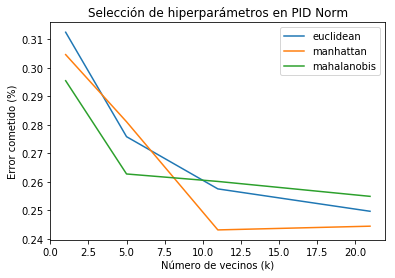

In [111]:
run_knnSK(dists, Ks, strat_cross_f5, db_pid_norm, "PID Norm")

Pues parece que hay otra coincidencia con nuestra implementación: normalizar los datos del dataset PID no aporta un sustancial beneficio. Esto ratifica lo que habíamos dicho de que este conjunto es fácilmente separable en su soporte de definción. Por otro lado, volvemos a corroborar que las 3 distancias aportan resultados similares, quizá la distancia de Manhattan tenga una precisión un poquito mayor (al menos en esta ejecución). Los mejores valores para k siguen siendo 11 y 21.

Concluimos que para el conjunto de entrenamiento PID usando Vecinos Proximos de SKLearn, los mejores hiperparámetros son a priori:
- **k igual a 11 ó 21**.
- **Distancia euclídea o de Manhattan**.

### 3.1.2 Dataset WDBC

Cambiamos ahora de conjunto de entrenamiento para centrarnos en el dataset WDBC.

#### 3.1.2.1 Datos sin normalizar

+---------------+-----------+-----------+-----------+-----------+
| distancia/K   |         1 |         5 |        11 |        21 |
+===============+===========+===========+===========+===========+
| euclidean     | 0.0849558 | 0.0672566 | 0.0619469 | 0.0707965 |
+---------------+-----------+-----------+-----------+-----------+
| manhattan     | 0.0778761 | 0.0672566 | 0.0654867 | 0.0725664 |
+---------------+-----------+-----------+-----------+-----------+
| mahalanobis   | 0.175221  | 0.182301  | 0.238938  | 0.277876  |
+---------------+-----------+-----------+-----------+-----------+


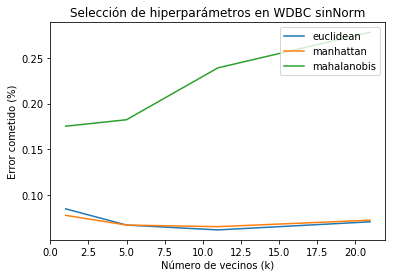

In [112]:
run_knnSK(dists, Ks, strat_cross_f5, db_wdbc_notNorm, "WDBC sinNorm")

Vemos que claramente la distancia de Mahalanobis es la peor. Entre las otras dos, euclídea y de Manhattan, no hay apenas diferencia. Estos resultados son equivalentes a los obtenidos en la sección 1 con nuestros propios métodos. Parece que el mejor valor de k es 11, aunque 5 y 21 no se alejan demasiado, pudiendo ser también buenos candidatos.

#### 3.1.2.2 Datos normalizados

+---------------+-----------+-----------+-----------+-----------+
| distancia/K   |         1 |         5 |        11 |        21 |
+===============+===========+===========+===========+===========+
| euclidean     | 0.0513274 | 0.0371681 | 0.0371681 | 0.0442478 |
+---------------+-----------+-----------+-----------+-----------+
| manhattan     | 0.0442478 | 0.0371681 | 0.0424779 | 0.0460177 |
+---------------+-----------+-----------+-----------+-----------+
| mahalanobis   | 0.161062  | 0.19292   | 0.215929  | 0.272566  |
+---------------+-----------+-----------+-----------+-----------+


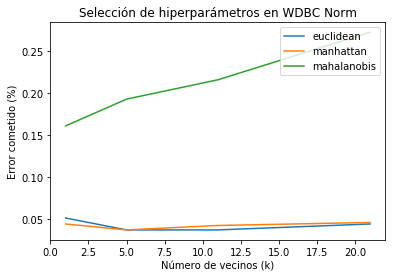

In [114]:
run_knnSK(dists, Ks, strat_cross_f5, db_wdbc_norm, "WDBC Norm")

La precisión ha aumentado sustancialmente normalizando los datos (pasó lo mismo en la sección 1). Ahora el error ha bajado del 5-7% al 2-4%. La distancia de Mahalanobis sigue siendo pésima para la clasificación de este dataset. Los mejores valores de k siguen siendo 5 y 11, pero 21 tampoco tiene un error mucho mayor, siendo viable.

Por tanto, podemos sostener que para el conjunto de datos WDBC usando Vecinos Próximos de SKLearn, los mejores hiperparámetros son:
- **k = 5, 11 ó 21**.
- **Distancia euclídea o de Manhattan**.

## <font color='blue'> 3.2 Regresión Logística de SKLearn </font>

Ahora analizamos otro modelo de SKLearn, Regresión Logística.

Es importante observar que la librería scikit-learn tiene dos clases que permiten implementar el algoritmo de regresión logística. La primera es claramente la clase **LogisticRegression**, y la segunda es **SGDCLassifer** con la función de coste **'log'**.

**LogisticRegression** está implementada usando diferentes funciones de coste a minimizar. Dependiendo de la norma que deseemos (L1, L2 o una combinación de ambas), la librería intentará minimizar una u otra. Por otro lado, está clase ya implementa automáticamente *regularización*, que es una técnica matemática para evitar sobreentrenar (*overfitting*) el conjunto de entrenamiento. Nosotros, en nuestra implementación de Regresión Logística, no incorporamos esta característica, ya que nos limitamos a codificar el algoritmo explicado en clase de teoría, pero sería una mejora interesante para un futuro. Adicionalmente, la librería SKLearn no utiliza un entrenamiento basado en número de épocas, sino que tú le puedes indicar un número **máximo** de épocas, pero esta podrá parar antes si considera que el gradiente es muy pequeño, introduciendo cambios insignificantes y considerando que el modelo ya ha convergido. Esta es la razón principal por la cual es posible que las celdas que ejecutan este método serán más rápidas que las que ejecutan nuestro modelo de regresión logística.

Por otro lado, **SGDClassifier** es un simple pero eficiente algoritmo para ajustar modelos lineales y regresiones usando funciones de coste convexas. En nuestro caso, podemos usar esta clase para implementar regresión logística si le indicamos que la función de coste es la logarítmica (loss='log'). Esta clase tiene muchas ventajas en cuanto a la anterior (LogisticRegression). En primer lugar, tiene todas las características de la anterior, utilizando un parámetro *tol* para decidir si el algoritmo ya ha convergido sin la necesidad de entrenar el número máximo de iteraciones. Segundo, LogisticRegression tiene que iterar sobre todos los datos para actualizar una sola vez los pesos (W), pero SGDClassifier puede escoger pequeños conjuntos (puede ser 1 ejemplo o un grupo de ejemplos, comúnmente llamado *mini-batch*), los cuales son escogidos de forma aleatoria (de ahí que se le denomine *Stochastic*). Adicionalmente, esto permite a la librería SKLearn paralelizar el entrenamiento, lo que hace que sea mucho más eficiente y rápido. Si tuviésemos un conjunto de datos de millones de ejemplos, en lugar de solo ~1000, deberíamos usar esta clase y no la otra. Sería interesante, para el futuro, "jugar" con otro tipos de parámetros, como usar otras funciones de coste u otros *solvers*.

Igual que en la sección de Vecinos Próximos con SKLearn, implementamos una función para ayudarnos a realizar todas las ejecuciones deseadas. 

In [43]:
# Funcion auxiliar para analizar el rendimiento de regresión logística con la librería sklearn.
# Recibe una lista de constantes de aprendizaje y una lista de número de épocas con las que ejecutar RL.
# El número de épocas será tomado por la librería de SKLearn como el número MÁXIMO de épocas,
# que no es lo mismo que hacemos nosotros. Por otro lado, recibe un argumento adicional 'sgd', que si es
# True usamos la clase de SKLearn SGDClassifier, mientras que si es False usamos LogisticRegression.
# Como salida, muestra una tabla con los errores medios obtenidos y una gráfica comparando los resultados.

def run_logRegSK(lr_list, epochs_list, dataset, db_name, strat, sgd=False):
    L = []
    for lr in lr_list:
        results = []
        for nepochs in epochs_list:
            RL = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=lr, nepochs=nepochs, sgd=sgd)
            errores = clasificador.validacion(strat, dataset, RL)
            err = (np.mean(errores), np.std(errores))
            results.append(err)
        l = [lr] + [str(round(item[0], 4))+' +- '+str(round(item[1],2)) for item in results]
        L.append(l)
        errs = [item[0] for item in results]
        plt.plot(epochs_list, errs, label='Learning rate: '+str(lr))

    print(tabulate(L, headers=['LR/nepocas']+epochs_list, tablefmt="grid"))

    plt.xlabel('Número de epocas (nepocas)')
    plt.ylabel('Error cometido (%)')
    plt.legend(loc='upper right')
    if sgd:
        plt.title('Selección de hiperparámetros en '+db_name+' (SGDClassifier)')
    else:
        plt.title('Selección de hiperparámetros en '+db_name+' (LogisticRegression)')
    plt.plot()

Para comenzar analizaremos 4 constantes de aprendizaje: 0.5, 0.1, 0.05 y 0.01. Próximamente ampliaremos esta lista. De igual forma, la lista de número de épocas será de un tamaño reducido. Es posible que en un futuro no se amplie ya que los métodos de SKLearn no interpretarán esta lista como número de épocas estricto a ejecutar, sino que será el número máximo de épocas, ya que tienen ciertas técnicas (*early-stopping*, variación de gradiente mínimo, etc.) para deter el aprendizaje antes de tiempo si este no va mejorando.

In [44]:
lr_list = [0.5, 0.1, 0.05, 0.01]
epochs_list = [200, 300, 400]

### 3.2.1 Dataset pima-indians-diabetes

+--------------+----------------+----------------+----------------+
|   LR/nepocas | 200            | 300            | 400            |
+==============+================+================+================+
|         0.5  | 0.2261 +- 0.04 | 0.2301 +- 0.02 | 0.2301 +- 0.06 |
+--------------+----------------+----------------+----------------+
|         0.1  | 0.2248 +- 0.02 | 0.2288 +- 0.04 | 0.2235 +- 0.04 |
+--------------+----------------+----------------+----------------+
|         0.05 | 0.2353 +- 0.03 | 0.2314 +- 0.04 | 0.2301 +- 0.02 |
+--------------+----------------+----------------+----------------+
|         0.01 | 0.2288 +- 0.01 | 0.2288 +- 0.02 | 0.2275 +- 0.03 |
+--------------+----------------+----------------+----------------+


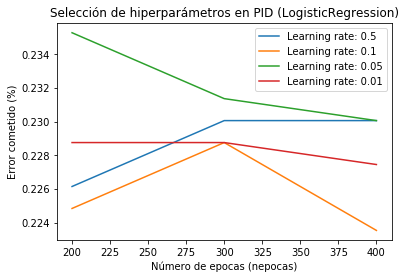

In [45]:
run_logRegSK(lr_list, epochs_list, db_pid_norm, 'PID', strat_cross_f5, sgd=False)

Los resultados varían poco con la clase de SKLearn LogisticRegression, el error se concentra entorno al 22% sea cual sea la constante de aprendizaje. En la sección final de resultados ejecutaremos el entrenamiento muchas veces para poder escoger con mayor respaldo estadístico la constante de aprendizaje adecuada. En cuanto al número de épocas, parece que no suscitan grandes cambios, posiblemente porque se esté convergiendo a un mínimo local/global antes de alcanzar el número de épocas máximo.

+--------------+----------+----------+----------+
|   LR/nepocas |      200 |      300 |      400 |
+==============+==========+==========+==========+
|         0.5  | 0.270588 | 0.320261 | 0.291503 |
+--------------+----------+----------+----------+
|         0.1  | 0.230065 | 0.237908 | 0.230065 |
+--------------+----------+----------+----------+
|         0.05 | 0.236601 | 0.23268  | 0.226144 |
+--------------+----------+----------+----------+
|         0.01 | 0.228758 | 0.228758 | 0.237908 |
+--------------+----------+----------+----------+


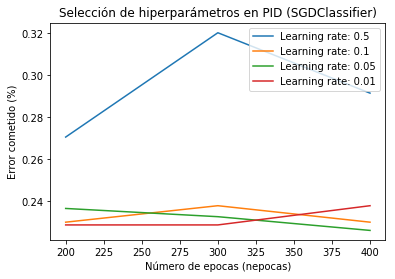

In [167]:
run_logRegSK(lr_list, epochs_list, db_pid_norm, 'PID', strat_cross_f5, sgd=True)

Con la clase SGDClassifier los mejores errores se concentran también entorno al 22%, pero ahora sí que parece que la constante lr=0.5 tiene un rendimiento muy inferior al resto. En futuras secciones ya ni lo tendremos en cuenta. De nuevo, en cuanto al número de épocas, este parece no tener un gran impacto en la precisión de los clasificadores con lr=0.1, 0.05 y 0.01.

### 3.2.2 Dataset WDBC

Analicemos ahora el dataset WDBC con SKLearn y sus dos formas de implementar RegresiónLogística.

+--------------+-----------+-----------+-----------+
|   LR/nepocas |       200 |       300 |       400 |
+==============+===========+===========+===========+
|         0.5  | 0.0230088 | 0.0176991 | 0.0300885 |
+--------------+-----------+-----------+-----------+
|         0.1  | 0.0265487 | 0.0247788 | 0.0212389 |
+--------------+-----------+-----------+-----------+
|         0.05 | 0.0176991 | 0.0230088 | 0.0230088 |
+--------------+-----------+-----------+-----------+
|         0.01 | 0.019469  | 0.0176991 | 0.0212389 |
+--------------+-----------+-----------+-----------+


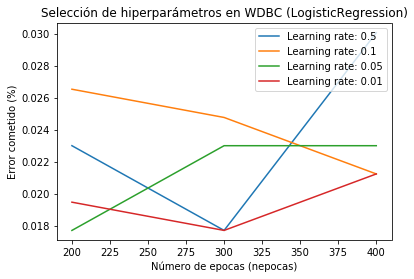

In [172]:
run_logRegSK(lr_list, epochs_list, db_wdbc_norm, 'WDBC', strat_cross_f5, sgd=False)

Usando la clase LogisticRegression los errores se concentran entorno al 2% y es muy difícil discernir si una constante de aprendizaje es mejor que otra, ya que dependiendo de la ejecución unas tiene mejor rendimiento que otras.

+--------------+-----------+-----------+-----------+
|   LR/nepocas |       200 |       300 |       400 |
+==============+===========+===========+===========+
|         0.5  | 0.0318584 | 0.0371681 | 0.0300885 |
+--------------+-----------+-----------+-----------+
|         0.1  | 0.0371681 | 0.0300885 | 0.0353982 |
+--------------+-----------+-----------+-----------+
|         0.05 | 0.0300885 | 0.0283186 | 0.0283186 |
+--------------+-----------+-----------+-----------+
|         0.01 | 0.0247788 | 0.0176991 | 0.0230088 |
+--------------+-----------+-----------+-----------+


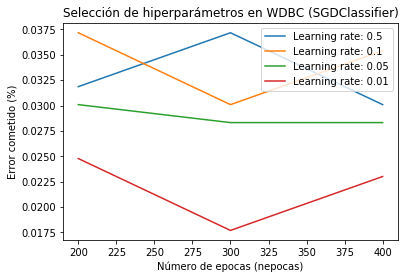

In [175]:
run_logRegSK(lr_list, epochs_list, db_wdbc_norm, 'WDBC', strat_cross_f5, sgd=True)

En cuanto a SGDClassifier, parece que el mejor ratio de aprendizaje es 0.0q, pero los errores siguen siendo demasiado pequeños para discernir el mejor hiperparámetro. De nuevo, el número de épocas máximo parece irrelevante. El modelo está convergiendo a un mínimo antes del número de iteraciones máximo.

## <font color='green'> 3.3 Comapración de resultados con nuestra implementación </font>

En esta sección vamos a centrarnos en averiguar qué clasificador utilizaríamos si deseásemos el mejor rendimiento dado un conjunto de datos. Por consiguiente ejecutaremos un gran número de veces cada uno de los clasificadores posibles (ya sea propio o de SKLearn) y calcularemos su error medio, para obtener el mejor clasificador así como sus hiperparámetros.

In [185]:
def get_bestClf(clfs_list, clfs_names, strat, dataset, t=100):
    res_dict = {}
    for (clf_idx, clf) in enumerate(clfs_list):
        mean_errors = []
        for i in range(t):
            errores = clasificador.validacion(strat, dataset, clf)
            mean_errors.append(np.mean(errores))
        res_dict[clfs_names[clf_idx]] = (np.mean(mean_errors), np.std(mean_errors))
    return res_dict
        

In [198]:
def print_res_dict(res_dict, dataset_name):
    headers = ['CLASIFICADOR', 'Dataset: '+dataset_name+'\nERRORES COMETIDOS']
    L = []
    for clf_name, clf_tup in res_dict.items():
        L.append([clf_name, str(clf_tup[0])+' +- '+str(clf_tup[1])])
    print(tabulate(L, headers=headers, tablefmt="pretty"))

### <font color='blue'> 3.3.1 Dataset pima-indians-diabetes </font>

Inicializamos la estrategia de particionado deseada: validación cruzada con 5 folds.

In [179]:
strat_cross_f5 = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

Creamos una lista con todos los mejores clasificadores utilizados hasta el momento. Para no desbordar el notebook, vamos a coger los clasificadores con los que tengamos *dudas*, es decir, aquellos que consideremos (por lo visto hasta ahora) los mejores para entrenar el dataset PID.

In [182]:
KNN_eucl_k21 = Clasificador.ClasificadorVecinosProximos(K=21, dist='euclidean')
KNN_manh_k21 = Clasificador.ClasificadorVecinosProximos(K=21, dist='manhattan')

KNNSK_eucl_k11 = Clasificador.ClasificadorVecinosProximosSK(K=11, dist='euclidean')
KNNSK_eucl_k21 = Clasificador.ClasificadorVecinosProximosSK(K=21, dist='euclidean')
KNNSK_manh_k11 = Clasificador.ClasificadorVecinosProximosSK(K=11, dist='manhattan')
KNNSK_manh_k21 = Clasificador.ClasificadorVecinosProximosSK(K=21, dist='manhattan')

RL_lr0005_300 = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.005, nepochs=300)
RL_lr0001_300 = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.001, nepochs=300)
RL_lr00005_300 = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.0005, nepochs=300)

RL_SKLR_lr0005_300 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.005, nepochs=300, sgd=False)
RL_SKLR_lr0001_300 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.001, nepochs=300, sgd=False)
RL_SKLR_lr00005_300 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.0005, nepochs=300, sgd=False)
RL_SKSGD_lr0005_300 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.005, nepochs=300, sgd=True)
RL_SKSGD_lr0001_300 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.001, nepochs=300, sgd=True)
RL_SKSGD_lr00005_300 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.0005, nepochs=300, sgd=True)

In [195]:
clfs_list = [KNN_eucl_k21, KNN_manh_k21, KNNSK_eucl_k11, KNNSK_eucl_k21, KNNSK_manh_k11, KNNSK_manh_k21,\
            RL_lr0005_300, RL_lr0001_300, RL_lr00005_300, RL_SKLR_lr0005_300, RL_SKLR_lr0001_300,\
            RL_SKLR_lr00005_300, RL_SKSGD_lr0005_300, RL_SKSGD_lr0001_300, RL_SKSGD_lr00005_300]

In [194]:
clfs_names = ['KNN-Euclidean-k21', 'KNN-Manhattan-k21', 'KNN-SK-Euclidean-k11', 'KNN-SK-Euclidean-k21', 'KNN-SK-Manhattan-k11',\
              'KNN-SK-Manhattan-k21', 'RL-lr0.005-300epocas', 'RL-lr0.001-300epocas', 'RL-lr0.0005-300epocas',\
              'RL-SKLR-lr0.005-300epocas', 'RL-SKLR-lr0.001-300epocas', 'RL-SKLR-lr0.0005-300epocas', \
              'RL-SKSGD-lr0.005-300epocas', 'RL-SKSGD-lr0.001-300epocas', 'RL-SKSGD-lr0.0005-300epocas']

In [199]:
res_dict = get_bestClf(clfs_list, clfs_names, strat_cross_f5, db_pid_norm, t=100)

In [200]:
print_res_dict(res_dict, 'Pima-Indians-Diabetes')

+-----------------------------+----------------------------------------------+
|        CLASIFICADOR         |        Dataset: Pima-Indians-Diabetes        |
|                             |              ERRORES COMETIDOS               |
+-----------------------------+----------------------------------------------+
|      KNN-Euclidean-k21      |  0.2484052287581699 +- 0.007297946847866477  |
|      KNN-Manhattan-k21      | 0.24688888888888885 +- 0.009380221288000097  |
|    KNN-SK-Euclidean-k11     | 0.26164705882352934 +- 0.0073312708993822015 |
|    KNN-SK-Euclidean-k21     | 0.25048366013071893 +- 0.0074102314237487615 |
|    KNN-SK-Manhattan-k11     |  0.2620522875816993 +- 0.00827659526218927   |
|    KNN-SK-Manhattan-k21     | 0.24700653594771238 +- 0.007538574671520444  |
|    RL-lr0.005-300epocas     |  0.2275816993464052 +- 0.00466760028009336   |
|    RL-lr0.001-300epocas     |        0.228 +- 0.004655430349594872         |
|    RL-lr0.0005-300epocas    | 0.22735947712418303 

### <font color='blue'> 3.3.2 Dataset WDBC </font>

In [201]:
KNN_eucl_k5 = Clasificador.ClasificadorVecinosProximos(K=5, dist='euclidean')
KNN_eucl_k11 = Clasificador.ClasificadorVecinosProximos(K=11, dist='euclidean')

KNNSK_eucl_k5 = Clasificador.ClasificadorVecinosProximosSK(K=5, dist='euclidean')
KNNSK_eucl_k11 = Clasificador.ClasificadorVecinosProximosSK(K=11, dist='euclidean')
KNNSK_eucl_k21 = Clasificador.ClasificadorVecinosProximosSK(K=21, dist='euclidean')
KNNSK_manh_k5 = Clasificador.ClasificadorVecinosProximosSK(K=5, dist='manhattan')
KNNSK_manh_k11 = Clasificador.ClasificadorVecinosProximosSK(K=11, dist='manhattan')
KNNSK_manh_k21 = Clasificador.ClasificadorVecinosProximosSK(K=21, dist='manhattan')

RL_lr0005_250 = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.005, nepochs=250)
RL_lr0001_250 = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.001, nepochs=250)
RL_lr00005_250 = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.0005, nepochs=250)

RL_SKLR_lr0005_250 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.005, nepochs=250, sgd=False)
RL_SKLR_lr0001_250 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.001, nepochs=250, sgd=False)
RL_SKLR_lr00005_250 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.0005, nepochs=250, sgd=False)
RL_SKSGD_lr0005_250 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.005, nepochs=250, sgd=True)
RL_SKSGD_lr0001_250 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.001, nepochs=250, sgd=True)
RL_SKSGD_lr00005_250 = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.0005, nepochs=250, sgd=True)

In [205]:
clfs_list_wdbc = [KNN_eucl_k5, KNN_eucl_k11, KNNSK_eucl_k5, KNNSK_eucl_k11, KNNSK_eucl_k21, KNNSK_manh_k5, \
                  KNNSK_manh_k11, KNNSK_manh_k21, RL_lr0005_250, RL_lr0001_250, RL_lr00005_250, \
                  RL_SKLR_lr0005_250, RL_SKLR_lr0001_250, RL_SKLR_lr00005_250, RL_SKSGD_lr0005_250, \
                  RL_SKSGD_lr0001_250, RL_SKSGD_lr00005_250]

In [206]:
clfs_names_wdbc = ['KNN-Euclidean-k5', 'KNN-Euclidean-k11', 'KNN-SK-Euclidean-k5', 'KNN-SK-Euclidean-k11', 'KNN-SK-Euclidean-k21',\
                   'KNN-SK-Manhattan-k5', 'KNN-SK-Manhattan-k11', 'KNN-SK-Manhattan-k21', 'RL-lr0.005-250epocas', 'RL-lr0.001-250epocas',\
                   'RL-lr0.0005-250epocas', 'RL-SKLR-lr0.005-250epocas', 'RL-SKLR-lr0.001-250epocas', 'RL-SKLR-lr0.0005-250epocas', \
                   'RL-SKSGD-lr0.005-250epocas', 'RL-SKSGD-lr0.001-250epocas', 'RL-SKSGD-lr0.0005-250epocas']

In [209]:
res_dict = get_bestClf(clfs_list_wdbc, clfs_names_wdbc, strat_cross_f5, db_wdbc_norm, t=100)

In [210]:
print_res_dict(res_dict, 'Pima-Indians-Diabetes')

+-----------------------------+-----------------------------------------------+
|        CLASIFICADOR         |        Dataset: Pima-Indians-Diabetes         |
|                             |               ERRORES COMETIDOS               |
+-----------------------------+-----------------------------------------------+
|      KNN-Euclidean-k5       | 0.03385840707964603 +- 0.0034013168134519657  |
|      KNN-Euclidean-k11      | 0.03433628318584072 +- 0.0033112012272335724  |
|     KNN-SK-Euclidean-k5     |  0.03348672566371683 +- 0.003279641719476238  |
|    KNN-SK-Euclidean-k11     | 0.03474336283185843 +- 0.0034561346144921013  |
|    KNN-SK-Euclidean-k21     | 0.04460176991150444 +- 0.0031759926451197075  |
|     KNN-SK-Manhattan-k5     | 0.034106194690265504 +- 0.0028741858803668445 |
|    KNN-SK-Manhattan-k11     | 0.03837168141592921 +- 0.0027971322145328706  |
|    KNN-SK-Manhattan-k21     | 0.04824778761061947 +- 0.0026914296503037665  |
|    RL-lr0.005-250epocas     | 0.024761

# <font color='red'>4. Análisis ROC </font>

In [6]:
def create_confMatrix(pred, real):
    i = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for pred_val in pred:
        # True negative
        if pred_val==0 and pred_val==real[i]:
            tn += 1
        # False negative
        elif pred_val==0 and pred_val!=real[i]:
            fn += 1
        # True positive
        elif pred_val==1 and pred_val==real[i]:
            tp += 1
        # False positive
        elif pred_val==1 and pred_val!=real[i]:
            fp += 1
        i += 1
    
    return [['PRED POS', tp, fp], ['PRED NEG', fn, tn]]




def print_confMatrix(m):
    headers = ["", "REAL POS", "REAL NEG"]
    print(tabulate(m, headers, tablefmt="grid")) 

In [7]:
def ROC_Analysis(dataset, clf, particionado, print_confMtx=True):
    seed = random.seed(0)
    np.random.shuffle(dataset.datos)
    particionado.creaParticiones(dataset.datos, seed)
    
    TPRs = [] # True positive ratios
    FPRs = [] # False positive ratios
    for particion in particionado.particiones:

        datostrain = dataset.datos[particion.indicesTrain, :]
        datostest = dataset.datos[particion.indicesTest, :]
            
        clf.entrenamiento(datostrain, dataset.nominalAtributos, dataset.diccionario)
            
        pred = clf.clasifica(datostest, dataset.nominalAtributos, dataset.diccionario)
        real = datostest[:,-1] 
        
        # Creating confusion matrix, calculating TPR and FPR.
        m = create_confMatrix(pred, real)
        tpr_aux = m[0][1]/(m[0][1] + m[1][1])
        fpr_aux = m[0][2]/(m[0][2] + m[1][2])
        TPRs.append(tpr_aux)
        FPRs.append(fpr_aux)
    
    # Calculating TPRs and FPRs mean
    tpr = np.mean(TPRs)
    fpr = np.mean(FPRs)
    
    # Printing confusion matrix (if we want to)
    if print_confMtx:
        print_confMatrix(m)
        print("Punto espacio ROC: (", fpr, ",", tpr, ")")

    return fpr, tpr
 

In [8]:
def plot_ROC(fpr, tpr, clf_name=None, dataset_name=None):
    plt.figure()
    
    rand_bins = np.linspace(0, 1, num=30)
    plt.plot(rand_bins, rand_bins, color='blue', linestyle='dashed', label='random clf')
    
    tpr_coords = [0, tpr, 1]
    fpr_coords = [0, fpr, 1]
    plt.plot(fpr_coords, tpr_coords, color='red', label='classifier')
    
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    if clf_name:
        plt.title('ROC space for '+clf_name)
    if dataset_name:
        plt.suptitle('Dataset used: '+dataset_name)
    else:
        plt.title('ROC space')

## <font color='blue'> 4.1 Naive-Bayes en los dos nuevos datasets </font>

En esta subsección nos vamos a centrar en ejecutar el modelo Naive-Bayes implementado en la práctica pasada para los dos nuevos conjuntos de entrenamiento. Adicionalmente, vamos a ver qué parámetros mejoran la precisión de clasificación de Naive-Bayes con ambos datasets, es decir, básicamente vamos a mirar si es fructífero usar la corrección de Laplace o no. 

Vamos a utilizar una estrategia de particionado de validación cruzada de 5 fold, que como vimos en la práctica anterior, no produce resultados muy dispares a los de validación simple con varias repeticiones.

### 4.1.1 NB en pima-indians-diabetes

In [11]:
NB = Clasificador.ClasificadorNaiveBayes(laplace=True) # laplace = True (default)
NB_noLaplace = Clasificador.ClasificadorNaiveBayes(laplace=False)

In [13]:
errores = clasificador.validacion(strat_cross_f5, db_pid_norm, NB)
print("Error medio: ", np.mean(errores), '+-', np.std(errores))

Error medio:  0.24444444444444446 +- 0.027606159584239075


In [14]:
errores = clasificador.validacion(strat_cross_f5, db_pid_norm, NB_noLaplace)
print("Error medio: ", np.mean(errores), '+-', np.std(errores))

Error medio:  0.24575163398692812 +- 0.026012743453767855


Parece que los resultados son muy parecidos, tanto si usamos la corrección de Laplace como si no. Vamos a asegurarnos.

In [16]:
T = 100
errores_laplace = []
errores_noLaplace = []
for i in range(T):
    errores = clasificador.validacion(strat_cross_f5, db_pid_norm, NB)
    errores_laplace += errores
    errores = clasificador.validacion(strat_cross_f5, db_pid_norm, NB_noLaplace)
    errores_noLaplace += errores
print("Error medio (usando Laplace): ", np.mean(errores_laplace), '+-', np.std(errores_laplace))
print("Error medio (sin Laplace): ", np.mean(errores_noLaplace), '+-', np.std(errores_noLaplace))

Error medio (usando Laplace):  0.24583006535947716 +- 0.03150127187015464
Error medio (sin Laplace):  0.2461176470588235 +- 0.032486792500307074


Vemos que el error con Laplace y sin Laplace es muy parecido, entorno al 24.5%. Si recordamos los resultados de la sección 3.3.1, Naive-Bayes parece tener un rendimiento muy similar al modelo Vecinos próximos y ligeramente peor que Regresión Logística.

Concluimos este apartado diciendo que si deseásemos entrenar y clasificar el dataset PID con Naive-Bayes podríamos usar ambas versiones, usando la corrección de Laplace o no, ya que producen los mismos resultados.

Veamos que pasa con el otro conjunto de datos.

### 4.1.2 NB en WDBC

In [27]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, NB)
print("Error medio: ", np.mean(errores), '+-', np.std(errores))

Error medio:  0.06725663716814159 +- 0.035220794233862644


In [28]:
errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, NB_noLaplace)
print("Error medio: ", np.mean(errores), '+-', np.std(errores))

Error medio:  0.0654867256637168 +- 0.017341520302889785


Parece de nuevo que la corrección de Laplace no aporta nada. Vamos a ejecutarlo varias veces para estar seguros.

In [29]:
T = 100
errores_laplace = []
errores_noLaplace = []
for i in range(T):
    errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, NB)
    errores_laplace += errores
    errores = clasificador.validacion(strat_cross_f5, db_wdbc_norm, NB_noLaplace)
    errores_noLaplace += errores
print("Error medio (usando Laplace): ", np.mean(errores_laplace), '+-', np.std(errores_laplace))
print("Error medio (sin Laplace): ", np.mean(errores_noLaplace), '+-', np.std(errores_noLaplace))

Error medio (usando Laplace):  0.06743362831858407 +- 0.021863243347317672
Error medio (sin Laplace):  0.06723893805309734 +- 0.021936187792629836


En ambos casos el error es idéntico. Entre 6.5 y 6.7% de error. Si recordamos los datos de la sección 3.3.2, parece que Naive-Bayes es el peor modelo de todos para intentar clasificar el dataset WDBC. En lo que queda de sección 4 utilizaremos el análisis ROC para intentar decidir qué clasificador finalmente usaríamos para itentar modelar cada uno de los conjuntos de datos.


Tanto para el conjunto PID, como para el WDBC, la corrección de Laplace no ha aportado ninguna mejora. En el análisis ROC ejecutaremos Naive-Bayes sin esta corrección para reducir el tiempo de ejecución.

## <font color='blue'> 4.2 Análisis ROC para pima-indians-diabetes </font>

Basádonos en el apartado 3.3.1 y en el 4.1.1 estudiaremos mediante el análisis ROC los modelos de esta práctica con los hiperparámetros que mejores resultados han dado para el conjunto de datos PID:
- **Vecinos Próximos** con distancia de **Manhattan** y **k=21**.
- **Vecinos Próximos** de **SKLearn** con distancia de **Manhattan** y **k=21**.
- **Regresión Logística** con **lr=0.0005** y **300 épocas**.
- **Regresión Logística** de **SKLearn** (**LogisticRegression** class) con **lr=0.001** y **300 épocas** (300 máximas épocas).
- **Regresión Logística** de **SKLearn** (**SGDClassifier** class) con **lr=0.001** y **300 épocas** (300 máximas épocas).
- **Naive-Bayes** **sin Laplace**.
- **Naive-Bayes** de **SKLearn** **con Laplace** (extra).



In [29]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=True)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         29 |         13 |
+----------+------------+------------+
| PRED NEG |         21 |         90 |
+----------+------------+------------+
Punto espacio ROC: ( 0.10798158241324123 , 0.47251523849617927 )


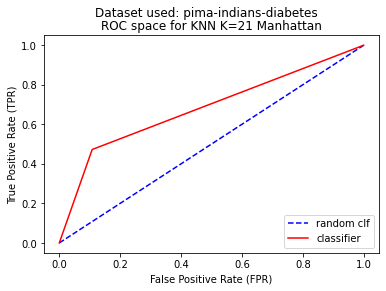

In [30]:
KNN_manh = Clasificador.ClasificadorVecinosProximos(K=21, dist='manhattan')
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, KNN_manh, strat)
plot_ROC(fpr, tpr, clf_name='KNN K=21 Manhattan', dataset_name='pima-indians-diabetes')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         23 |         15 |
+----------+------------+------------+
| PRED NEG |         27 |         88 |
+----------+------------+------------+
Punto espacio ROC: ( 0.11445774627340217 , 0.4687020697167756 )


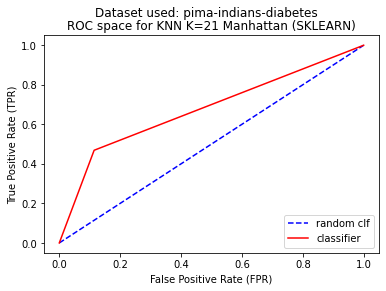

In [31]:
KNNSK_manh = Clasificador.ClasificadorVecinosProximosSK(K=21, dist='manhattan')
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, KNNSK_manh, strat)
plot_ROC(fpr, tpr, clf_name='KNN K=21 Manhattan (SKLEARN)', dataset_name='pima-indians-diabetes')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         19 |         15 |
+----------+------------+------------+
| PRED NEG |         21 |         98 |
+----------+------------+------------+
Punto espacio ROC: ( 0.11148959371418939 , 0.5572212095896306 )


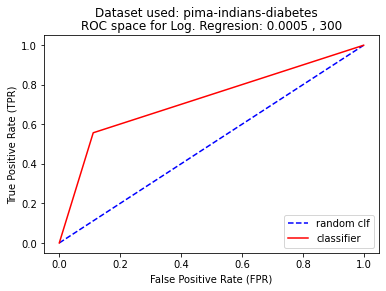

In [32]:
LR = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.0005, nepochs=300)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, LR, strat)
plot_ROC(fpr, tpr, clf_name='Log. Regresion: 0.0005 , 300', dataset_name='pima-indians-diabetes')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         27 |          6 |
+----------+------------+------------+
| PRED NEG |         32 |         88 |
+----------+------------+------------+
Punto espacio ROC: ( 0.11151832968283164 , 0.5644899102227119 )


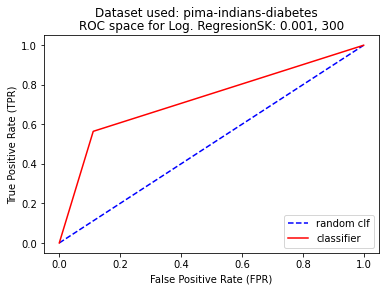

In [33]:
LRSK = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.001, nepochs=300, sgd=False)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, LRSK, strat)
plot_ROC(fpr, tpr, clf_name='Log. RegresionSK: 0.001, 300', dataset_name='pima-indians-diabetes')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         31 |          9 |
+----------+------------+------------+
| PRED NEG |         29 |         84 |
+----------+------------+------------+
Punto espacio ROC: ( 0.12048560115111948 , 0.5624318693488128 )


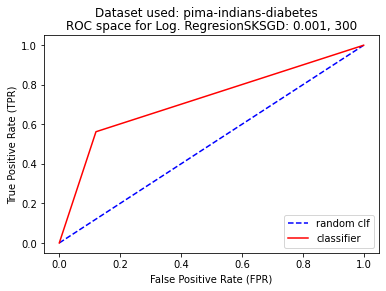

In [34]:
LRSKSGD = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.001, nepochs=300, sgd=True)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, LRSK, strat)
plot_ROC(fpr, tpr, clf_name='Log. RegresionSKSGD: 0.001, 300', dataset_name='pima-indians-diabetes')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         28 |         20 |
+----------+------------+------------+
| PRED NEG |         25 |         80 |
+----------+------------+------------+
Punto espacio ROC: ( 0.17237857042223328 , 0.5922095672650611 )


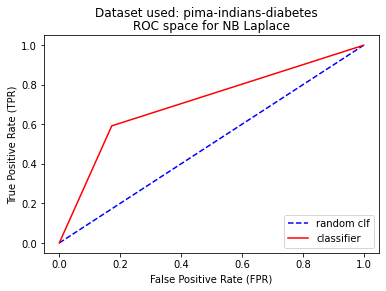

In [35]:
NB = Clasificador.ClasificadorNaiveBayes(laplace=True)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, NB, strat)
plot_ROC(fpr, tpr, clf_name='NB Laplace', dataset_name='pima-indians-diabetes')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         38 |         21 |
+----------+------------+------------+
| PRED NEG |         19 |         75 |
+----------+------------+------------+
Punto espacio ROC: ( 0.14856086388152165 , 0.5925176496389443 )


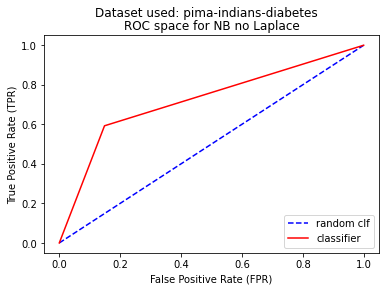

In [36]:
NB_noLaplace = Clasificador.ClasificadorNaiveBayes(laplace=False)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, NB_noLaplace, strat)
plot_ROC(fpr, tpr, clf_name='NB no Laplace', dataset_name='pima-indians-diabetes')

Tras ver los resultados obtenidos, vemos que claramente el espacio ROC obtenido es bastante parecido para los tres. 

Primero vamos a hablar sobre KNN, este clasificador da tanto un FPR como un TPR más bajo que el resto. Tanto el algoritmo implementado por nosotros como el de SKLEARN dan resultados muy parecidos. 

Logistic Regresion ha sido el siguiente en la lista, y hemos ejecutado el análisis de 3 variantes: nuesto algoritmo y las versiones (Logistic Regresion class), (SGDClassifier class) de SKLearn. De nuevo las 3 variantes se desempeñan de forma muy parecida. El punto en el espacio ROC que nos da este algoritmo tiene un TPR bastante más alto que KNN, y un FPR un poco más alto que KNN. 

Finalmente analizamos Naïve Bayes, el algoritmo usado en la práctica anterior. Vemos que este algoritmo tiene más alto FPR y TPR que el reto de algoritmos. En cuanto al desempeño de ambas versiones, vemos como NB sin Laplace se comporta mucho mejor que la versión con Laplace, ya que disminiye de forma notable el FPR.

Visualmente el mejor algoritmo es Logistic Regresion, ya que es el que mejor relación tiene entre maximizar TPR y minimizar el FPR. Sin embargo estamos haciendo el estudio ROC en base a una DB de una enfermedad y en contextos médicos nos interesa maximizar el TPR a toda costa, ya que el coste de diagnosticar un Falso Negativo es muy alto en comparación con un Falso Positivo. Por tanto, nos quedaríamos con NB como el mejor clasificador para este caso.



## <font color='blue'> 4.3 Análisis ROC para WDBC </font>

Basádonos en el apartado 3.3.2 y en el 4.1.2 estudiaremos mediante el análisis ROC los modelos de esta práctica con los hiperparámetros que mejores resultados han dado para el conjunto de datos WDBC:
- **Vecinos Próximos** con distancia **euclídea** y **k=5**.
- **Vecinos Próximos** de **SKLearn** con distancia **euclídea** y **k=5**.
- **Regresión Logística** con **lr=0.001** y **250 épocas**.
- **Regresión Logística** de **SKLearn** (**LogisticRegression** class) con **lr=0.005** y **250 épocas** (300 máximas épocas).
- **Regresión Logística** de **SKLearn** (**SGDClassifier** class) con **lr=0.005** y **250 épocas** (300 máximas épocas).
- **Naive-Bayes** **sin Laplace**.
- **Naive-Bayes** de **SKLearn** **con Laplace** (extra).

In [38]:
db_wdbc = Datos('../ConjuntosDatos/wdbc.data', normalize=True)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         27 |         20 |
+----------+------------+------------+
| PRED NEG |         23 |         83 |
+----------+------------+------------+
Punto espacio ROC: ( 0.15940711289467813 , 0.5462760501909438 )


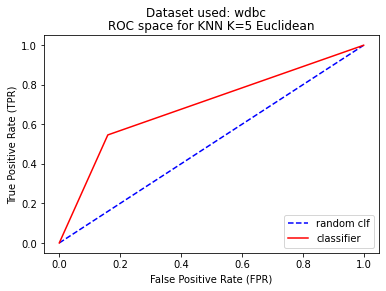

In [39]:
KNN_euc = Clasificador.ClasificadorVecinosProximos(K=5, dist='euclidean')
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, KNN_euc, strat)
plot_ROC(fpr, tpr, clf_name='KNN K=5 Euclidean', dataset_name='wdbc')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         27 |         17 |
+----------+------------+------------+
| PRED NEG |         32 |         77 |
+----------+------------+------------+
Punto espacio ROC: ( 0.14485648263929313 , 0.5274345146379045 )


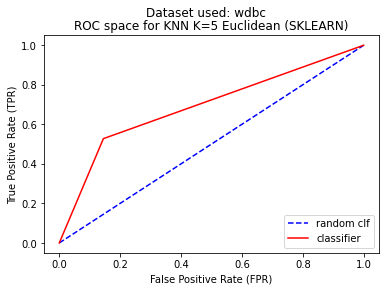

In [40]:
KNNSK_euc = Clasificador.ClasificadorVecinosProximosSK(K=5, dist='euclidean')
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, KNNSK_euc, strat)
plot_ROC(fpr, tpr, clf_name='KNN K=5 Euclidean (SKLEARN)', dataset_name='wdbc')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         36 |         15 |
+----------+------------+------------+
| PRED NEG |         25 |         77 |
+----------+------------+------------+
Punto espacio ROC: ( 0.11647677013577853 , 0.5789946063376314 )


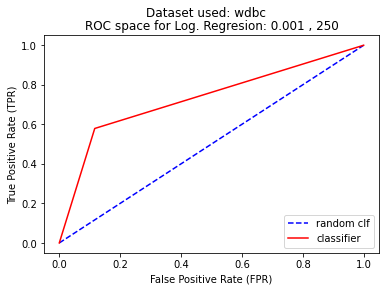

In [41]:
LR = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.001, nepochs=250)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, LR, strat)
plot_ROC(fpr, tpr, clf_name='Log. Regresion: 0.001 , 250', dataset_name='wdbc')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         34 |         12 |
+----------+------------+------------+
| PRED NEG |         23 |         84 |
+----------+------------+------------+
Punto espacio ROC: ( 0.11973001966744143 , 0.5600410578278003 )


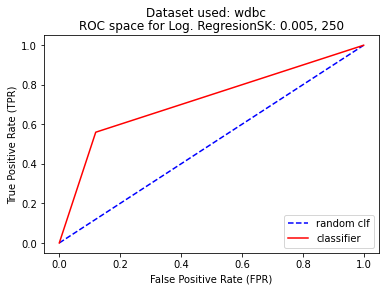

In [42]:
LRSK = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.001, nepochs=300, sgd=False)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, LRSK, strat)
plot_ROC(fpr, tpr, clf_name='Log. RegresionSK: 0.005, 250', dataset_name='wdbc')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         32 |         14 |
+----------+------------+------------+
| PRED NEG |         18 |         89 |
+----------+------------+------------+
Punto espacio ROC: ( 0.11386951914011414 , 0.5740201174486889 )


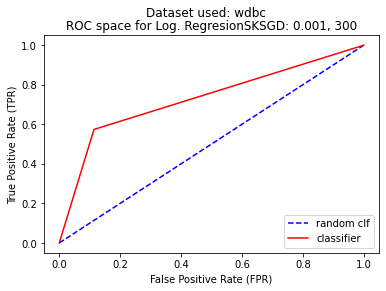

In [44]:
LRSKSGD = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.001, nepochs=300, sgd=True)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, LRSK, strat)
plot_ROC(fpr, tpr, clf_name='Log. RegresionSKSGD: 0.001, 300', dataset_name='wdbc')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         27 |         17 |
+----------+------------+------------+
| PRED NEG |         18 |         91 |
+----------+------------+------------+
Punto espacio ROC: ( 0.15505025022745156 , 0.6149547548776093 )


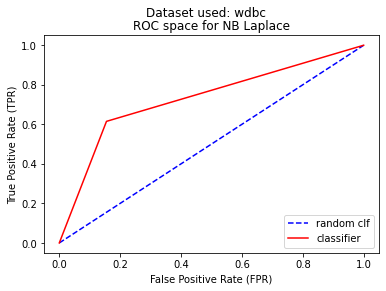

In [45]:
NB = Clasificador.ClasificadorNaiveBayes(laplace=True)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, NB, strat)
plot_ROC(fpr, tpr, clf_name='NB Laplace', dataset_name='wdbc')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         31 |         17 |
+----------+------------+------------+
| PRED NEG |         19 |         86 |
+----------+------------+------------+
Punto espacio ROC: ( 0.16519724564434776 , 0.6113803763534571 )


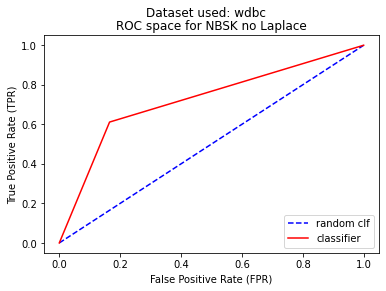

In [46]:
NBSK_noLaplace = Clasificador.ClasificadorNaiveBayesSK(laplace=False)
strat = EstrategiaParticionado.ValidacionCruzada(5)
fpr, tpr = ROC_Analysis(db_pid, NB_noLaplace, strat)
plot_ROC(fpr, tpr, clf_name='NBSK no Laplace', dataset_name='wdbc')

De nuevo, al igual que en apartado anterior, salen espacios ROC muy parecidos.

Para esta Base de Datos, claramente KNN es el peor clasificador, ya que es el que pero relación tiene de TPR y FPR. En cuanto a las dos versiones debemos de comentar que nuestra implementación tiene un ratio menor tanto de TPR como de TPR, lo cual no es conveniente en este caso.

Logistic Regresion, visualmente, de nuevo es el mejor clasificador, ya que reduce bastante los FTR y aumenta el TPR. En cuanto a las tres implementaciones son muy parecidas y no se observan discrepancias importantes.

Finalmente NB es el clasificador con el mayor TPR, pero también el mayor FPR. Ambas implementaciones no difieren de forma importante.

De nuevo estamos analizando una DB médica, en este caso intenta predecir si un paciente padece Cancer. Como en el caso anterior nos tenemos que quedar con el clasificador que nos de un mayor TPR. De nuevo tenemos que elegir Naïve Bayes como el mejor clasificador.